In [ ]:
import matplotlib.pyplot as plt
from google.colab import files
import numpy as np
import os
import cv2
from PIL import Image
from torchvision.ops import SqueezeExcitation
from sklearn.model_selection import KFold
import pandas as pd
from google.colab import drive

In [ ]:
# import libraries and data
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision import transforms, datasets
from torchvision.transforms import Resize

from tqdm import tqdm
import time
from scipy import stats

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from sklearn.metrics import classification_report
from statistics import mean

print(torch.cuda.is_available())
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

True


In [ ]:
class EarlyStopping:
    def __init__(self, patience=4, min_delta=0.001):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 5
            min_delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                               Default: 0
        """
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = np.inf
        self.counter = 0
        self.early_stop = False

    def __call__(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


In [ ]:
img_size = (1, 128, 128)
num_classes = 4
label_map = {} #To store the class id and class name

In [ ]:
def autopad(k, p=None):  # kernel, padding
    # Pad to 'same'
    if p is None:
        p = k // 2 if isinstance(k, int) else [x // 2 for x in k]  # auto-pad
    return p


class Conv(nn.Module):
    # Standard convolution
    def __init__(self, c1, c2, k=1, s=1, p=None, d=1, g=1, att=None):  # ch_in, ch_out, kernel, stride, padding, groups
        super().__init__()

        self.conv = nn.Conv2d(c1, c2, k, s, autopad(k, p), dilation=d, groups=g, bias=False)
        self.bn = nn.BatchNorm2d(c2)
        self.act = nn.ReLU()
        self.att = nn.Identity() if att is None else (SqueezeExcitation(c2, int(c2/4)) if att == 'SE' else CBAM(c2, ratio=4))

    def forward(self, x):
        return self.att(self.act(self.bn(self.conv(x))))


class ChannelAttention(nn.Module):
    def __init__(self, channels, ratio=4, pool_types=['avg', 'max']):
        super(ChannelAttention, self).__init__()
        self.channels = channels

        self.globalAvgPool = nn.AdaptiveAvgPool2d(1)
        self.globalMaxPool = nn.AdaptiveMaxPool2d(1)

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(channels, channels // ratio),
            nn.ReLU(),
            nn.Linear(channels // ratio, channels)
            )
        self.pool_types = pool_types
        self.act = nn.Sigmoid()

    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = self.globalAvgPool(x)
                channel_att_raw = self.mlp(avg_pool)
            elif pool_type=='max':
                max_pool = self.globalMaxPool(x)
                channel_att_raw = self.mlp(max_pool)

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = self.act(channel_att_sum).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale


class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1)


class SpatialAttention(nn.Module):
    def __init__(self):
        super(SpatialAttention, self).__init__()
        kernel_size = 3
        self.compress = ChannelPool()
        self.spatial = Conv(2, 1, kernel_size)
        self.act = nn.Sigmoid()

    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = self.act(x_out)
        return x * scale


class CBAM(nn.Module):
    def __init__(self, channels, ratio=4, pool_types=['avg', 'max'], spatial=True):
        super(CBAM, self).__init__()
        self.ch_att = ChannelAttention(channels, ratio, pool_types)
        self.spatial=spatial
        if spatial:
            self.sp_att = SpatialAttention()

    def forward(self, x):
        x = self.ch_att(x)
        if self.spatial:
            x = self.sp_att(x)
        return x


class FeaturePyramidBlock(nn.Module):
    def __init__(self, channels, att=None):
        super().__init__()
        self.conv0 = Conv(channels[0], 32, 3, att=att)
        self.conv1 = Conv(32+channels[1], 32, 3, att=att)

        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.avgpool0 = nn.AdaptiveAvgPool2d(8)
        self.avgpool1 = nn.AdaptiveMaxPool2d(8)
        self.convf = Conv(64, 32, 1, att=att)

    def forward(self, x0, x1):
        x0_ = self.conv0(x0)
        x00_ = self.avgpool0(x0_)
        x11_ = self.avgpool1(self.conv1(torch.cat((self.up(x0_),x1), dim=1)))
        x = torch.cat((x00_, x11_), dim=1)
        x = self.convf(x).flatten(1)
        return x


def plot_loss_accuracy(train_loss, validation_loss, validation_acc):
    epochs = len(train_loss)
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(4, 8))
    plt.setp((ax1, ax2), xticks=range(0, epochs+1))

    ax1.plot(list(range(1, epochs+1)), train_loss, label='Training Loss')
    ax1.plot(list(range(1, epochs+1)), validation_loss, label='Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss vs Epoch')
    ax1.legend()

    ax2.plot(list(range(1, epochs+1)), validation_acc, label='Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy vs Epoch')
    ax2.legend(loc= 'lower right')
    ax2.set_ylim([0, 1])
    fig.tight_layout()

    plt.show()


def plot_confusion_matrix(Y_test, Yhat):
    # calculate and plot confusion matrix
    cm = confusion_matrix(Y_test, Yhat, labels=range(num_classes))    # calculate the confusion matrix
    # plt.figure(2)                                                             # setup new figure
    # sns.heatmap(cm/np.sum(cm), annot=True, fmt=".2%", cmap="Blues",)          # plot the confusion matrix using the sns package
    # plt.title("Confusion Matrix", fontsize = 12)                              # title
    # plt.xlabel("Predicted Class", fontsize = 12)                              # xlabel
    # plt.ylabel("True Class", fontsize = 12)                                   # ylabel
    # plt.show()                                                                # show plot
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    disp.plot()
    plt.show()


def evaluate(model=None, dataloader=None, criterion=None, device='cpu', report_pth=None):
    Y_val, Yhat = [], []
    correct = 0
    total = 0
    running_val_loss = 0.0

    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        model.eval()
        for j, data in enumerate(dataloader):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # calculate outputs by running images through the network
            outputs = model(images)

            loss = criterion(outputs, labels)
            running_val_loss += loss.item()

            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)

            Y_val.extend(labels.tolist())
            Yhat.extend(predicted.tolist())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #Accuray
    acc = correct / total

    #Validation loss
    val_loss = running_val_loss / (j+1)

    # Generate the classification report
    if report_pth is not None:
        report = classification_report(Y_val, Yhat, target_names=list(label_map.values()))

        # Save the report to a text file
        with open(report_pth, 'w') as file:
            file.write(report)

        print(f'Classification report saved to {report_pth}')

    return acc, val_loss


def train(model=None, epochs=1, trainloader=None, valloader=None, device='cpu', save_pth=None, verbose=0, csv_path=None):
    #loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0005)
    #optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=optimizer, gamma=0.9) #adding a learning rate scheduler helps.

    train_epoch_loss = []
    val_epoch_loss = []
    val_epoch_acc = []

    best_acc = 0.0
    nb = len(trainloader)  # number of batches

    # Evaluate the model once before training
    best_acc, _ = evaluate(model, valloader, criterion, device, report_pth=None)

    # Training logs
    train_log = []
    train_log.append({
        'epoch': 0,
        'train_loss': 'nan',
        'val_loss': 'nan',
        'val_accuracy': best_acc})

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=4, min_delta=0.0001)

    # Start training
    t0 = time.time()

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        pbar = enumerate(trainloader)
        if verbose: print(('\n' + '%10s' * 2) % ('Epoch', 'mloss'))
        pbar = tqdm(pbar, total=nb, bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}') if verbose else pbar  # progress bar
        running_loss = 0.0

        for i, data in pbar:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            if verbose: pbar.set_description(('%10s' * 2) % (f'{epoch + 1}/{epochs}', f'{running_loss / (i+1):.3f}'))

        lr_scheduler.step()
        train_epoch_loss.append(running_loss / (i+1))

        #Evaluate at the end of the epoch
        fi, vloss = evaluate(model, valloader, criterion, device, report_pth=None)
        val_epoch_loss.append(vloss)
        if verbose: print(('%20s') % (f'Accuracy : {100 * fi:.3f} %'))

        # Update best accuracy and save the weights
        val_epoch_acc.append(fi)
        if fi > best_acc:
            best_acc = fi
            pc = 0 # Reset the patience counter
            if save_pth is not None:
                torch.save(model.state_dict(), save_pth)

        # Early stopping check
        early_stopping(val_epoch_loss[-1])
        if early_stopping.early_stop:
          print(f'Early stopping triggered after {epoch+1} epochs')
          break

    if verbose:
        print(f'\n{epoch+1} epochs completed in {(time.time() - t0) / 3600:.3f} hours.')
        #Plot the loss and accuracy for every epoch
        plot_loss_accuracy(train_epoch_loss, val_epoch_loss, val_epoch_acc)

    if csv_path is not None:
        # Append train log data
        for ep in range(epoch+1):
            train_log.append({
                'epoch': ep + 1,
                'train_loss': train_epoch_loss[ep],
                'val_loss': val_epoch_loss[ep],
                'val_accuracy': val_epoch_acc[ep]})

        # Convert to DataFrame
        df = pd.DataFrame(train_log)

        # Save to CSV
        df.to_csv(csv_path, index=False)
        print(f'Training logs saved to {csv_path}')

    #Evaluate the best model from this fold
    #Load the saved model
    model.load_state_dict(torch.load(save_pth, map_location=device))
    best_acc, _ = evaluate(model, valloader, criterion, device, report_pth=csv_path.replace('.csv', '.txt'))
    print(('%20s') % (f'Final evaluation, accuracy : {100 * best_acc:.3f} %'))

    return best_acc


def visualise_data(dataloader, classes):
    # Display images and labels from the train dataset.
    batch = next(iter(dataloader))
    batch_size = len(batch[0])

    cols, rows = 4, 4
    fig = plt.figure(figsize=(batch_size//2, batch_size//2))
    for i in range(batch_size):
        #get the image and label
        image = batch[0][i].numpy()
        image = image.transpose((1, 2, 0)) #CxHxW -> HxWxC
        image = (image * 255.0).astype("uint8")

        idx = batch[1][i].item() #label id
        label = classes[idx]

        fig.add_subplot(batch_size//4, 4, i+1)
        plt.title(label)
        plt.axis("off")
        plt.imshow(image, cmap='gray')

    fig.tight_layout()
    plt.show()
    plt.close()


def reset_weights(m):
    '''
    Resetting model weights to avoid weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            #print(f'Reset trainable parameters of layer = {layer}')
            layer.reset_parameters()


In [ ]:
drive.mount('/content/drive')

#!unzip -q /content/drive/MyDrive/Brain\ Tumor\ MRI\ Dataset.zip

transform1 = transforms.Compose([transforms.Grayscale(), Resize(img_size[1:], Image.BILINEAR), transforms.RandomHorizontalFlip(p=0.2), transforms.RandomVerticalFlip(p=0.2), transforms.ToTensor()])
transform2 = transforms.Compose([transforms.Grayscale(), Resize(img_size[1:], Image.BILINEAR), transforms.ToTensor()])

trainset = datasets.ImageFolder(root='/content/Training/', transform=transform1)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=16, shuffle=True)

testset = datasets.ImageFolder(root='/content/Testing', transform=transform2)
testloader = torch.utils.data.DataLoader(testset, batch_size=16, shuffle=True)

label_map = {value:key for key, value in testset.class_to_idx.items()}
print(label_map)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{0: 'glioma', 1: 'meningioma', 2: 'notumor', 3: 'pituitary'}


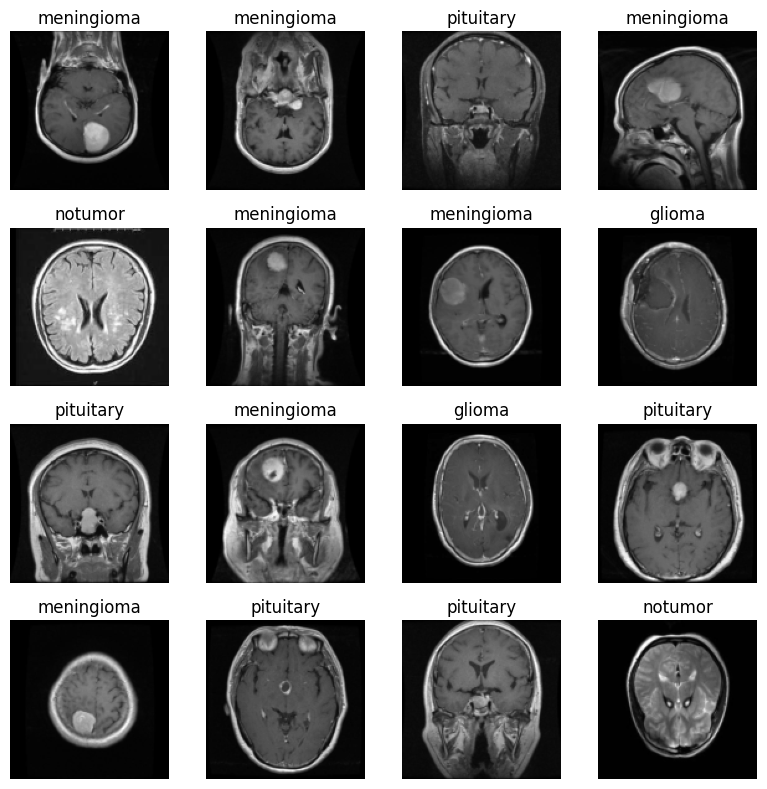

In [ ]:
# Display images and labels from the train dataset.
visualise_data(trainloader, label_map)

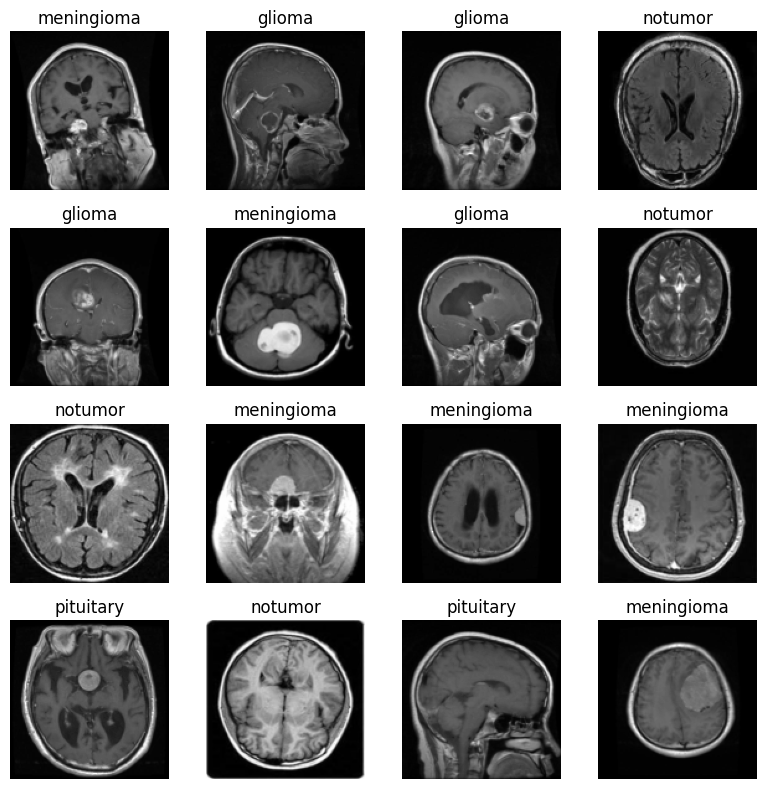

In [ ]:

# Display images and labels from the test dataset.
visualise_data(testloader, label_map)

In [ ]:
# class Model(nn.Module):
#     def __init__(self, nc=None, p=None): #nc = number of classes, p = probability of the units retained
#         super().__init__()
#         self.conv1 = Conv(1, 16, 3)
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.conv2 = Conv(16, 32, 3)
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.conv3 = Conv(32, 48, 3)
#         self.pool3 = nn.MaxPool2d(2, 2)
#         self.conv4 = Conv(48, 64, 3)
#         self.fpn = FeaturePyramidBlock((64, 48))
#         self.drop = nn.Dropout(p)
#         self.fc = nn.Linear(2048, nc)


#     def forward(self, x):
#         x = self.pool1(self.conv1(x))
#         x = self.pool2(self.conv2(x))
#         x1 = self.conv3(x)
#         x = self.pool3(x1)
#         x0 = self.conv4(x)
#         x = self.fpn(x0,x1)
#         x = self.drop(x)
#         x = self.fc(x)
#         return x


# class Model(nn.Module):
#     def __init__(self, nc=None, p=None): #nc = number of classes, p = probability of the units retained
#         super().__init__()
#         self.conv1 = Conv(1, 16, 3, att='SE')
#         self.pool1 = nn.MaxPool2d(2, 2)
#         self.conv2 = Conv(16, 32, 3, att='SE')
#         self.pool2 = nn.MaxPool2d(2, 2)
#         self.conv3 = Conv(32, 48, 3, att='SE')
#         self.pool3 = nn.MaxPool2d(2, 2)
#         self.conv4 = Conv(48, 64, 3, att='SE')
#         self.fpn = FeaturePyramidBlock((64, 48), att='SE')
#         self.drop = nn.Dropout(p)
#         self.fc = nn.Linear(2048, nc)


#     def forward(self, x):
#         x = self.pool1(self.conv1(x))
#         x = self.pool2(self.conv2(x))
#         x1 = self.conv3(x)
#         x = self.pool3(x1)
#         x0 = self.conv4(x)
#         x = self.fpn(x0,x1)
#         x = self.drop(x)
#         x = self.fc(x)
#         return x


class Model(nn.Module):
    def __init__(self, nc=None, p=None): #nc = number of classes, p = probability of the units retained
        super().__init__()
        self.conv1 = Conv(1, 16, 3, att='CBAM')
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = Conv(16, 32, 3, att='CBAM')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.conv3 = Conv(32, 48, 3, att='CBAM')
        self.pool3 = nn.MaxPool2d(2, 2)
        self.conv4 = Conv(48, 64, 3, att='CBAM')
        self.fpn = FeaturePyramidBlock((64, 48), att='CBAM')
        self.drop = nn.Dropout(p)
        self.fc = nn.Linear(2048, nc)


    def forward(self, x):
        x = self.pool1(self.conv1(x))
        x = self.pool2(self.conv2(x))
        x1 = self.conv3(x)
        x = self.pool3(x1)
        x0 = self.conv4(x)
        x = self.fpn(x0,x1)
        x = self.drop(x)
        x = self.fc(x)
        return x

In [ ]:
model = Model(nc=num_classes, p=0.4).to(device)  # create

#Dry run to inspect the model
x = torch.randn(img_size).unsqueeze(0).to(device) #1xcxhxw
out = model(x)
print(model)

Model(
  (conv1): Conv(
    (conv): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (act): ReLU()
    (att): CBAM(
      (ch_att): ChannelAttention(
        (globalAvgPool): AdaptiveAvgPool2d(output_size=1)
        (globalMaxPool): AdaptiveMaxPool2d(output_size=1)
        (mlp): Sequential(
          (0): Flatten(start_dim=1, end_dim=-1)
          (1): Linear(in_features=16, out_features=4, bias=True)
          (2): ReLU()
          (3): Linear(in_features=4, out_features=16, bias=True)
        )
        (act): Sigmoid()
      )
      (sp_att): SpatialAttention(
        (compress): ChannelPool()
        (spatial): Conv(
          (conv): Conv2d(2, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act): ReLU()
          (att): Identity()
        


     Epoch     mloss


      1/20     0.684: 100%|██████████| 357/357 [00:26<00:00, 13.44it/s]


 Accuracy : 77.040 %

     Epoch     mloss


      2/20     0.418: 100%|██████████| 357/357 [00:26<00:00, 13.22it/s]


 Accuracy : 84.744 %

     Epoch     mloss


      3/20     0.310: 100%|██████████| 357/357 [00:26<00:00, 13.36it/s]


 Accuracy : 86.957 %

     Epoch     mloss


      4/20     0.248: 100%|██████████| 357/357 [00:26<00:00, 13.52it/s]


 Accuracy : 90.847 %

     Epoch     mloss


      5/20     0.193: 100%|██████████| 357/357 [00:26<00:00, 13.52it/s]


 Accuracy : 92.449 %

     Epoch     mloss


      6/20     0.168: 100%|██████████| 357/357 [00:25<00:00, 13.88it/s]


 Accuracy : 93.059 %

     Epoch     mloss


      7/20     0.146: 100%|██████████| 357/357 [00:25<00:00, 13.89it/s]


 Accuracy : 95.347 %

     Epoch     mloss


      8/20     0.127: 100%|██████████| 357/357 [00:25<00:00, 14.20it/s]


 Accuracy : 94.889 %

     Epoch     mloss


      9/20     0.110: 100%|██████████| 357/357 [00:24<00:00, 14.33it/s]


 Accuracy : 95.118 %

     Epoch     mloss


     10/20     0.088: 100%|██████████| 357/357 [00:24<00:00, 14.28it/s]


 Accuracy : 96.873 %

     Epoch     mloss


     11/20     0.076: 100%|██████████| 357/357 [00:25<00:00, 13.90it/s]


 Accuracy : 96.873 %

     Epoch     mloss


     12/20     0.076: 100%|██████████| 357/357 [00:26<00:00, 13.71it/s]


 Accuracy : 97.712 %

     Epoch     mloss


     13/20     0.060: 100%|██████████| 357/357 [00:26<00:00, 13.66it/s]


 Accuracy : 97.864 %

     Epoch     mloss


     14/20     0.053: 100%|██████████| 357/357 [00:25<00:00, 13.74it/s]


 Accuracy : 97.712 %

     Epoch     mloss


     15/20     0.065: 100%|██████████| 357/357 [00:25<00:00, 13.83it/s]


 Accuracy : 98.322 %

     Epoch     mloss


     16/20     0.053: 100%|██████████| 357/357 [00:25<00:00, 14.10it/s]


 Accuracy : 98.474 %

     Epoch     mloss


     17/20     0.051: 100%|██████████| 357/357 [00:25<00:00, 14.25it/s]


 Accuracy : 98.322 %

     Epoch     mloss


     18/20     0.040: 100%|██████████| 357/357 [00:26<00:00, 13.69it/s]


 Accuracy : 98.322 %

     Epoch     mloss


     19/20     0.037: 100%|██████████| 357/357 [00:25<00:00, 13.74it/s]


 Accuracy : 98.322 %

     Epoch     mloss


     20/20     0.036: 100%|██████████| 357/357 [00:25<00:00, 13.75it/s]


 Accuracy : 98.703 %

20 epochs completed in 0.165 hours.


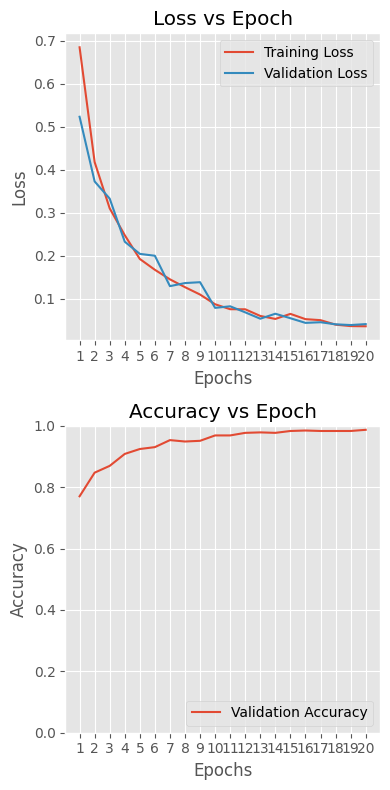

Training logs saved to /content/cbam_aug.csv
Classification report saved to /content/cbam_aug.txt
Final evaluation, accuracy : 98.703 %
Model best accuracy = 0.9870327993897788


In [ ]:
acc = train(model=model, epochs=20, trainloader=trainloader, valloader=testloader, device=device, save_pth='/content/best_model_cbam_aug.pth', verbose=1, csv_path='/content/cbam_aug.csv')
print(f'Model best accuracy = {acc}')

In [ ]:
k_folds = 5
kfold = KFold(n_splits=k_folds, shuffle=True)
split_indices = kfold.split(trainset)

Fold 0: In Progress...

     Epoch     mloss


      1/20     0.650: 100%|██████████| 286/286 [00:20<00:00, 13.73it/s]


 Accuracy : 82.327 %

     Epoch     mloss


      2/20     0.365: 100%|██████████| 286/286 [00:20<00:00, 14.27it/s]


 Accuracy : 86.002 %

     Epoch     mloss


      3/20     0.255: 100%|██████████| 286/286 [00:19<00:00, 14.66it/s]


 Accuracy : 90.289 %

     Epoch     mloss


      4/20     0.190: 100%|██████████| 286/286 [00:20<00:00, 13.95it/s]


 Accuracy : 92.301 %

     Epoch     mloss


      5/20     0.138: 100%|██████████| 286/286 [00:21<00:00, 13.42it/s]


 Accuracy : 92.476 %

     Epoch     mloss


      6/20     0.103: 100%|██████████| 286/286 [00:20<00:00, 14.22it/s]


 Accuracy : 92.388 %

     Epoch     mloss


      7/20     0.078: 100%|██████████| 286/286 [00:19<00:00, 14.67it/s]


 Accuracy : 94.138 %

     Epoch     mloss


      8/20     0.056: 100%|██████████| 286/286 [00:21<00:00, 13.62it/s]


 Accuracy : 94.401 %

     Epoch     mloss


      9/20     0.041: 100%|██████████| 286/286 [00:19<00:00, 14.33it/s]


 Accuracy : 91.514 %

     Epoch     mloss


     10/20     0.032: 100%|██████████| 286/286 [00:19<00:00, 14.54it/s]


 Accuracy : 94.838 %

     Epoch     mloss


     11/20     0.029: 100%|██████████| 286/286 [00:20<00:00, 14.18it/s]


 Accuracy : 94.576 %

     Epoch     mloss


     12/20     0.022: 100%|██████████| 286/286 [00:20<00:00, 13.74it/s]


 Accuracy : 94.488 %

     Epoch     mloss


     13/20     0.016: 100%|██████████| 286/286 [00:19<00:00, 14.60it/s]


 Accuracy : 94.838 %

     Epoch     mloss


     14/20     0.013: 100%|██████████| 286/286 [00:20<00:00, 14.26it/s]


 Accuracy : 94.576 %
Early stopping triggered after 14 epochs

14 epochs completed in 0.092 hours.


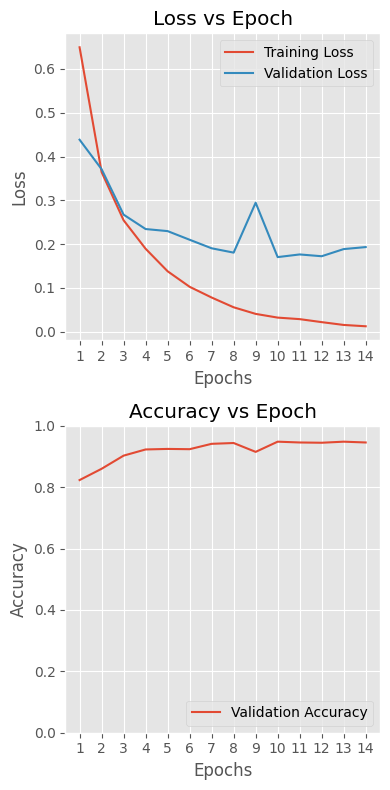

Training logs saved to /content/cbam/fold0.csv
Classification report saved to /content/cbam/fold0.txt
Final evaluation, accuracy : 94.576 %
Fold 0: Model best accuracy = 0.9483814523184602
Fold 1: In Progress...

     Epoch     mloss


      1/20     0.646: 100%|██████████| 286/286 [00:20<00:00, 14.26it/s]


 Accuracy : 68.854 %

     Epoch     mloss


      2/20     0.359: 100%|██████████| 286/286 [00:20<00:00, 14.03it/s]


 Accuracy : 86.177 %

     Epoch     mloss


      3/20     0.252: 100%|██████████| 286/286 [00:21<00:00, 13.60it/s]


 Accuracy : 89.676 %

     Epoch     mloss


      4/20     0.175: 100%|██████████| 286/286 [00:20<00:00, 14.06it/s]


 Accuracy : 93.701 %

     Epoch     mloss


      5/20     0.126: 100%|██████████| 286/286 [00:20<00:00, 14.27it/s]


 Accuracy : 92.126 %

     Epoch     mloss


      6/20     0.086: 100%|██████████| 286/286 [00:21<00:00, 13.61it/s]


 Accuracy : 92.738 %

     Epoch     mloss


      7/20     0.066: 100%|██████████| 286/286 [00:21<00:00, 13.46it/s]


 Accuracy : 95.188 %

     Epoch     mloss


      8/20     0.059: 100%|██████████| 286/286 [00:20<00:00, 14.13it/s]


 Accuracy : 95.801 %

     Epoch     mloss


      9/20     0.032: 100%|██████████| 286/286 [00:19<00:00, 14.44it/s]


 Accuracy : 96.413 %

     Epoch     mloss


     10/20     0.025: 100%|██████████| 286/286 [00:21<00:00, 13.59it/s]


 Accuracy : 95.451 %

     Epoch     mloss


     11/20     0.023: 100%|██████████| 286/286 [00:20<00:00, 13.74it/s]


 Accuracy : 96.063 %

     Epoch     mloss


     12/20     0.010: 100%|██████████| 286/286 [00:19<00:00, 14.36it/s]


 Accuracy : 96.763 %

     Epoch     mloss


     13/20     0.010: 100%|██████████| 286/286 [00:20<00:00, 13.94it/s]


 Accuracy : 95.976 %

     Epoch     mloss


     14/20     0.011: 100%|██████████| 286/286 [00:20<00:00, 13.72it/s]


 Accuracy : 96.325 %

     Epoch     mloss


     15/20     0.009: 100%|██████████| 286/286 [00:20<00:00, 13.86it/s]


 Accuracy : 96.413 %

     Epoch     mloss


     16/20     0.004: 100%|██████████| 286/286 [00:19<00:00, 14.36it/s]


 Accuracy : 96.063 %
Early stopping triggered after 16 epochs

16 epochs completed in 0.106 hours.


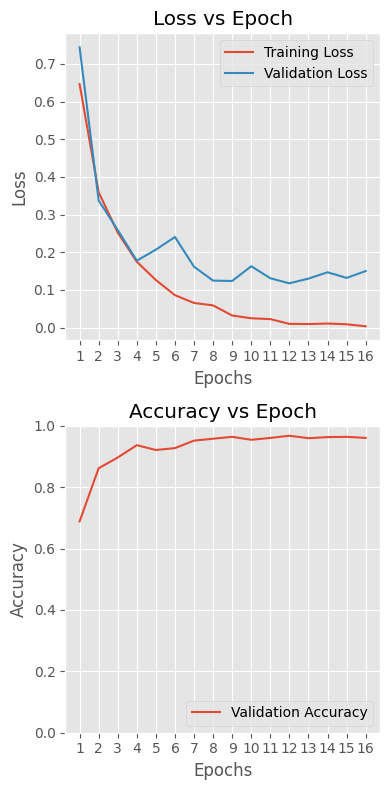

Training logs saved to /content/cbam/fold1.csv
Classification report saved to /content/cbam/fold1.txt
Final evaluation, accuracy : 96.063 %
Fold 1: Model best accuracy = 0.9676290463692039
Fold 2: In Progress...

     Epoch     mloss


      1/20     0.654: 100%|██████████| 286/286 [00:20<00:00, 13.79it/s]


 Accuracy : 87.128 %

     Epoch     mloss


      2/20     0.356: 100%|██████████| 286/286 [00:20<00:00, 14.04it/s]


 Accuracy : 89.405 %

     Epoch     mloss


      3/20     0.262: 100%|██████████| 286/286 [00:20<00:00, 13.83it/s]


 Accuracy : 91.156 %

     Epoch     mloss


      4/20     0.188: 100%|██████████| 286/286 [00:21<00:00, 13.41it/s]


 Accuracy : 92.119 %

     Epoch     mloss


      5/20     0.137: 100%|██████████| 286/286 [00:20<00:00, 13.92it/s]


 Accuracy : 93.082 %

     Epoch     mloss


      6/20     0.092: 100%|██████████| 286/286 [00:20<00:00, 14.08it/s]


 Accuracy : 94.483 %

     Epoch     mloss


      7/20     0.069: 100%|██████████| 286/286 [00:20<00:00, 13.62it/s]


 Accuracy : 89.667 %

     Epoch     mloss


      8/20     0.053: 100%|██████████| 286/286 [00:21<00:00, 13.41it/s]


 Accuracy : 93.958 %

     Epoch     mloss


      9/20     0.040: 100%|██████████| 286/286 [00:20<00:00, 14.13it/s]


 Accuracy : 95.184 %

     Epoch     mloss


     10/20     0.028: 100%|██████████| 286/286 [00:20<00:00, 14.17it/s]


 Accuracy : 94.571 %

     Epoch     mloss


     11/20     0.015: 100%|██████████| 286/286 [00:21<00:00, 13.00it/s]


 Accuracy : 95.271 %

     Epoch     mloss


     12/20     0.014: 100%|██████████| 286/286 [00:21<00:00, 13.38it/s]


 Accuracy : 95.096 %

     Epoch     mloss


     13/20     0.010: 100%|██████████| 286/286 [00:20<00:00, 13.93it/s]


 Accuracy : 95.271 %
Early stopping triggered after 13 epochs

13 epochs completed in 0.088 hours.


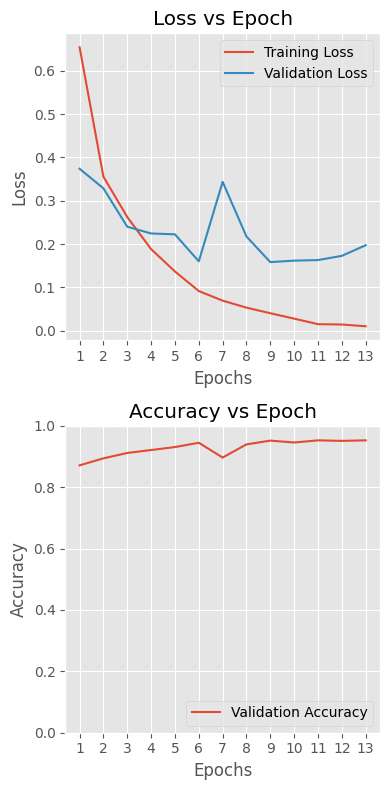

Training logs saved to /content/cbam/fold2.csv
Classification report saved to /content/cbam/fold2.txt
Final evaluation, accuracy : 95.271 %
Fold 2: Model best accuracy = 0.9527145359019265
Fold 3: In Progress...

     Epoch     mloss


      1/20     0.628: 100%|██████████| 286/286 [00:21<00:00, 13.15it/s]


 Accuracy : 88.266 %

     Epoch     mloss


      2/20     0.362: 100%|██████████| 286/286 [00:20<00:00, 13.76it/s]


 Accuracy : 89.667 %

     Epoch     mloss


      3/20     0.264: 100%|██████████| 286/286 [00:20<00:00, 13.91it/s]


 Accuracy : 90.543 %

     Epoch     mloss


      4/20     0.206: 100%|██████████| 286/286 [00:21<00:00, 13.40it/s]


 Accuracy : 90.368 %

     Epoch     mloss


      5/20     0.156: 100%|██████████| 286/286 [00:21<00:00, 13.09it/s]


 Accuracy : 94.571 %

     Epoch     mloss


      6/20     0.101: 100%|██████████| 286/286 [00:21<00:00, 13.52it/s]


 Accuracy : 95.884 %

     Epoch     mloss


      7/20     0.083: 100%|██████████| 286/286 [00:20<00:00, 14.13it/s]


 Accuracy : 95.096 %

     Epoch     mloss


      8/20     0.058: 100%|██████████| 286/286 [00:20<00:00, 13.77it/s]


 Accuracy : 95.009 %

     Epoch     mloss


      9/20     0.040: 100%|██████████| 286/286 [00:21<00:00, 13.12it/s]


 Accuracy : 95.184 %

     Epoch     mloss


     10/20     0.023: 100%|██████████| 286/286 [00:21<00:00, 13.37it/s]


 Accuracy : 95.972 %

     Epoch     mloss


     11/20     0.021: 100%|██████████| 286/286 [00:20<00:00, 13.93it/s]


 Accuracy : 96.322 %

     Epoch     mloss


     12/20     0.019: 100%|██████████| 286/286 [00:20<00:00, 13.85it/s]


 Accuracy : 96.673 %

     Epoch     mloss


     13/20     0.013: 100%|██████████| 286/286 [00:21<00:00, 13.12it/s]


 Accuracy : 96.585 %

     Epoch     mloss


     14/20     0.009: 100%|██████████| 286/286 [00:21<00:00, 13.44it/s]


 Accuracy : 96.060 %

     Epoch     mloss


     15/20     0.012: 100%|██████████| 286/286 [00:20<00:00, 13.89it/s]


 Accuracy : 96.235 %

     Epoch     mloss


     16/20     0.007: 100%|██████████| 286/286 [00:20<00:00, 13.78it/s]


 Accuracy : 96.585 %
Early stopping triggered after 16 epochs

16 epochs completed in 0.109 hours.


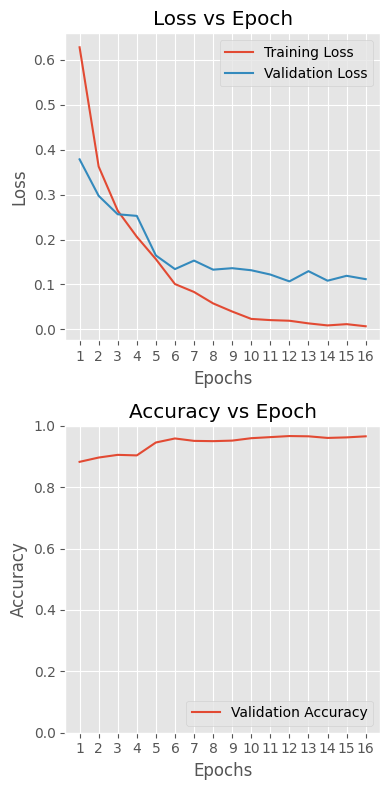

Training logs saved to /content/cbam/fold3.csv
Classification report saved to /content/cbam/fold3.txt
Final evaluation, accuracy : 96.585 %
Fold 3: Model best accuracy = 0.9667250437828371
Fold 4: In Progress...

     Epoch     mloss


      1/20     0.616: 100%|██████████| 286/286 [00:20<00:00, 13.77it/s]


 Accuracy : 83.450 %

     Epoch     mloss


      2/20     0.311: 100%|██████████| 286/286 [00:20<00:00, 13.76it/s]


 Accuracy : 91.856 %

     Epoch     mloss


      3/20     0.218: 100%|██████████| 286/286 [00:21<00:00, 13.19it/s]


 Accuracy : 89.317 %

     Epoch     mloss


      4/20     0.151: 100%|██████████| 286/286 [00:22<00:00, 12.94it/s]


 Accuracy : 94.308 %

     Epoch     mloss


      5/20     0.095: 100%|██████████| 286/286 [00:21<00:00, 13.55it/s]


 Accuracy : 93.958 %

     Epoch     mloss


      6/20     0.081: 100%|██████████| 286/286 [00:20<00:00, 13.70it/s]


 Accuracy : 93.170 %

     Epoch     mloss


      7/20     0.051: 100%|██████████| 286/286 [00:21<00:00, 13.56it/s]


 Accuracy : 95.622 %

     Epoch     mloss


      8/20     0.038: 100%|██████████| 286/286 [00:21<00:00, 13.21it/s]


 Accuracy : 95.271 %

     Epoch     mloss


      9/20     0.031: 100%|██████████| 286/286 [00:21<00:00, 13.26it/s]


 Accuracy : 95.271 %

     Epoch     mloss


     10/20     0.017: 100%|██████████| 286/286 [00:20<00:00, 13.76it/s]


 Accuracy : 95.359 %

     Epoch     mloss


     11/20     0.014: 100%|██████████| 286/286 [00:20<00:00, 13.77it/s]


 Accuracy : 95.797 %

     Epoch     mloss


     12/20     0.010: 100%|██████████| 286/286 [00:21<00:00, 13.26it/s]


 Accuracy : 95.709 %

     Epoch     mloss


     13/20     0.007: 100%|██████████| 286/286 [00:21<00:00, 13.07it/s]


 Accuracy : 96.497 %
Early stopping triggered after 13 epochs

13 epochs completed in 0.090 hours.


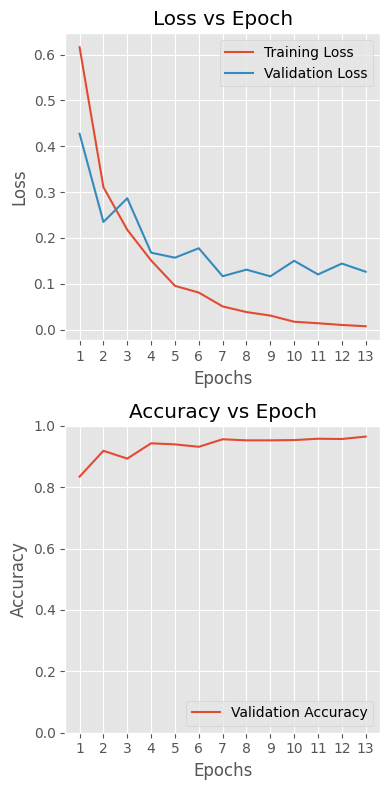

Training logs saved to /content/cbam/fold4.csv
Classification report saved to /content/cbam/fold4.txt
Final evaluation, accuracy : 96.497 %
Fold 4: Model best accuracy = 0.9649737302977233
The average accurcy of 5-Fold Cross Validation is 0.9600847617340301


In [ ]:
# K-fold Cross Validation model evaluation
kfold_acc = []
for fold, (train_ids, val_ids) in enumerate(split_indices):
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.Subset(trainset, train_ids)
    val_subsampler = torch.utils.data.Subset(trainset, val_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(train_subsampler, batch_size=16, shuffle=True)
    valloader = torch.utils.data.DataLoader(val_subsampler, batch_size=16, shuffle=True)

    # Init the neural network
    model.apply(reset_weights)

    #Train
    print(f'Fold {fold}: In Progress...')
    acc = train(model=model, epochs=20, trainloader=trainloader, valloader=valloader, device=device, save_pth='/content/cbam/best_model_fold'+str(fold)+'.pth', verbose=1, csv_path='/content/cbam/fold'+str(fold)+'.csv')
    kfold_acc.append(acc)
    print(f'Fold {fold}: Model best accuracy = {acc}')

print(f'The average accurcy of {k_folds}-Fold Cross Validation is {mean(kfold_acc)}')

In [ ]:
idx = [i for i, (x, y) in enumerate(zip(Y_test, Yhat)) if x != y]
id = {j//8:j%8 for j in idx}

f = 0
fig = plt.figure(figsize=(16, 16))
with torch.no_grad():
    model.eval()
    for data in testloader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        # calculate outputs by running images through the network
        outputs = model(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)

        mismatch = [i for i, (x, y) in enumerate(zip(labels, predicted)) if x != y]
        for d in mismatch:
            image = images[d].cpu().numpy()
            image = image.transpose((1, 2, 0)) #CxHxW -> HxWxC
            image = (image * 255.0).astype("uint8")
            idx = labels[d].item() #label id
            label = label_map[idx]
            pred_label = label_map[predicted[d].item()]

            fig.add_subplot(8, 4, f+1)
            f+=1
            plt.title(label+','+pred_label)
            plt.axis("off")
            plt.imshow(image, cmap='gray')

fig.tight_layout()
plt.show()
plt.close()


KeyError: 1

<Figure size 1600x1600 with 0 Axes>